# **0. Introduction**

> The **CICIDS2017 dataset** is a comprehensive collection of network traffic data, designed for evaluating **Intrusion Detection Systems (IDS)**.
This notebook focuses on preparing the dataset for machine learning (ML) models by implementing a thorough data cleaning and feature engineering pipeline.  

## ***Why CICIDS2017?***






> - This dataset replicates real-world network traffic with both normal and attack scenarios.  
- It includes a variety of modern cyberattacks, making it suitable for evaluating IDS models.  
- It has a well-defined structure but requires careful preprocessing to be used effectively in ML models.







## ***Objectives of This Notebook:***

## ***>>>Mount Google Drive (For Google Colab users)***

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')


## ***>>>Importing the relevant libraries***

In [3]:
# 1. Importing Required Libraries
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt

import seaborn as sns

import os

# 2. Importing Machine Learning and Statistical Tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

from scipy import stats
from scipy.stats import kruskal

# **1. Initial Exploration**



>The first step is to **load, merge, and explore** the dataset to understand its structure, data types, and potential issues such as missing values.  


## ***1.1. Loading the Dataset***


>We first load the **CICIDS2017 dataset**, which is stored in multiple CSV files. These files contain network traffic data with different types of attacks. We will read all CSV files into a dictionary and verify that they are loaded correctly.  


In [7]:

# Define the dataset directory
#folder_path = "/content/drive/MyDrive/dataset/"
folder_path = r"D:\university\Scientific python\dataset"

if not os.path.exists(folder_path):
    raise FileNotFoundError(f"no path: {folder_path}")

# Find all CSV files in the folder
#csv_files = glob.glob(folder_path + "*.csv")
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Dictionary to store datasets
datasets = {}

# Load each CSV file
for file in csv_files:
    #filename = file.split("/")[-1]
    filename = os.path.basename(file)
    try:
        df = pd.read_csv(file, low_memory=False)
        datasets[filename] = df
        print(f" {filename} successful")
    except Exception as e:
        print(f"error {filename}: {e}")

# Display an overview of each dataset
for name, df in datasets.items():
    print(f"dataset {name}")
    print(df.head(3))
    print(df.info(verbose=False, memory_usage="deep"))
    print("=" * 80)
  


 Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv successful
 Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv successful
 Friday-WorkingHours-Morning.pcap_ISCX.csv successful
 Monday-WorkingHours.pcap_ISCX.csv successful
 Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv successful
 Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv successful
 Tuesday-WorkingHours.pcap_ISCX.csv successful
 Wednesday-workingHours.pcap_ISCX.csv successful
dataset Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   

    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Columns: 79 entries,  Destination Port to  Label
dtypes: float64(24), int64(54), object(1)
memory usage: 110.4 MB
None
dataset Tuesday-WorkingHours.pcap_ISCX.csv
    Destination Port   Flow Duration   Total Fwd Packets  \
0                 88             640                   7   
1                 88             900                   9   
2                 88            1205                   7   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        4                          440   
1                        4                          600   
2                        4                         2776   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                           358                     220   
1                          2944                     300   
2                          2830                    1388   

    Fwd Packet Length Min   Fwd Packet Length

## ***1.2. Merging the DataFrames***



>Since the CICIDS2017 dataset is spread across multiple files, we need to merge them into a single dataset.
A unified dataset allows better preprocessing, feature engineering, and model training.

In [8]:
# combining all the files in our datasets Merging the DataFrames
data = pd.concat(datasets.values(), axis=0, ignore_index=True)

# Remove the original dictionary to free up memory
del datasets

# Display the shape of the merged dataset
print("Merging successful!")
print(f"Final dataset shape: {data.shape[0]} rows and {data.shape[1]} columns")


Merging successful!
Final dataset shape: 2830743 rows and 79 columns


## ***1.3. Data Overview***

>Now that we have a single dataset, we perform an initial exploration to understand its structure.

In [9]:

# Display the first few rows
print("First 5 rows of the dataset:")
display(data.head())

# Display 10 random rows to check for irregularities
print("Random sample (10 rows):")
display(data.sample(n=10, random_state=42))

# Check dataset dimensions
print(f" Dataset dimensions: {data.shape[0]} rows and {data.shape[1]} columns")

# Display data types distribution
print(" Data types in the dataset:")
display(data.dtypes.value_counts())


First 5 rows of the dataset:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Random sample (10 rows):


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,50545,232,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
946912,53,31226,2,2,68,380,34,34,34.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2216843,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.0,0.0,999,999,99900000.0,0.0,99900000,99900000,DoS Hulk
699389,53,30894,4,2,140,172,35,35,35.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1170268,53,48943,2,2,88,166,44,44,44.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
800686,53,23728,1,1,56,84,56,56,56.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1434488,23,3,2,0,4,0,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1968368,80,141,2,0,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
934343,443,229,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
693547,443,176084,10,8,559,5437,192,0,55.900000,78.196974,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


 Dataset dimensions: 2830743 rows and 79 columns
 Data types in the dataset:


int64      54
float64    24
object      1
Name: count, dtype: int64

The number of missing values may initially seem irrelevant; however, we can decide on the approach after further analysis.

### *Checking for Missing Values*
Missing values can affect model performance. We check for them and visualize their distribution.

 Missing values in the dataset:


Flow Bytes/s    0.047973
dtype: float64

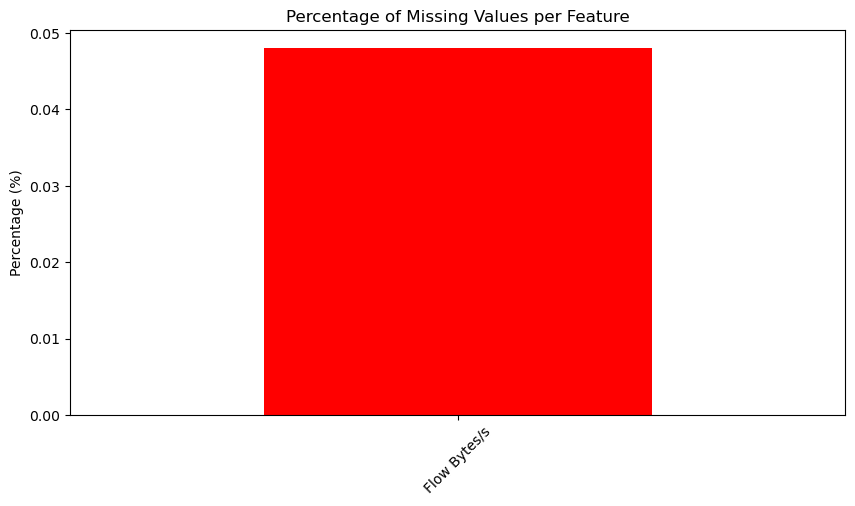

In [10]:

# Calculate missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Display only columns with missing values
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(" Missing values in the dataset:")
if not missing_data.empty:
    display(missing_data)
else:
    print(" No missing values found!")

#  Display a bar chart of missing data percentages (if any exist)
if not missing_data.empty:
    plt.figure(figsize=(10, 5))
    missing_data.plot(kind="bar", color="red")
    plt.title("Percentage of Missing Values per Feature")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45)
    plt.show()



### *Statistical Summary of Numerical Features*

In [11]:

# Display summary statistics
print(" Statistical summary of numerical features:")
display(data.describe())



 Statistical summary of numerical features:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


### *Checking Class Distribution*
If the dataset contains labels for attack types, we check how they are distributed.

In [12]:
# Check the number of samples per class (if labels exist)
target_col = "Label"
if target_col in data.columns:
    class_counts = data[target_col].value_counts().sort_values(ascending=False)
    print("Class distribution in the dataset:")
    display(data[target_col].value_counts())


    # Visualizing class distribution
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_counts.index, class_counts.values, color="royalblue", log=True)
    plt.title("Class Distribution in the Dataset", fontsize=14)
    plt.xlabel("Attack Type", fontsize=12)
    plt.ylabel("Number of Samples (Log Scale)", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}',
                 ha='center', va='bottom', fontsize=9, color='black')
    plt.grid(axis="y", linestyle="--", alpha=0.7)

# **2. Data Cleaning**

>Data cleaning is a crucial step in preparing the **CICIDS2017 dataset** for machine learning. This section focuses on:  
1. **Handling Duplicates & Identical Columns**  
2. **Detecting and Replacing Infinite Values**  
3. **Handling Missing Values**  
4. **Memory Optimization**

## ***2.1. Duplicates and Infinite***

### ***2.1.1. Handling Duplicates and Identical Columns***

***Removing Leading/Trailing Whitespaces from Column Names***





>Column names sometimes have extra spaces, which can cause inconsistencies.

In [13]:
# Remove leading/trailing whitespace in column names
data.columns = data.columns.str.strip()


***Checking and Removing Duplicate Rows***

>Duplicate rows can introduce bias in the model.

In [14]:
# Count duplicate rows
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicate rows if any exist
if duplicate_count > 0:
    data = data.drop_duplicates(keep='first')
    print("Duplicate rows removed.")

print(f"Dataset shape after removing duplicate rows: {data.shape}")

Number of duplicate rows: 308381
Duplicate rows removed.
Dataset shape after removing duplicate rows: (2522362, 79)


***Identifying & Removing Identical Columns***

>Some columns might contain identical data and can be removed.

In [16]:
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2 and data[col1].equals(data[col2]):
            if col1 not in identical_columns and col1 in list_control:
                identical_columns[col1] = [col2]
                list_control.remove(col2)
            elif col1 in identical_columns and col1 in list_control:
                identical_columns[col1].append(col2)
                list_control.remove(col2)

# Print the result and remove identical columns
if identical_columns:
    print(" Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")

    # Drop identical columns
    for key, value in identical_columns.items():
        data.drop(columns=value, inplace=True)
    print(" Identical columns removed.")
print(f"Dataset shape after column removal:  {data.shape}")


Dataset shape after column removal:  (2522362, 67)


### ***2.1.2. Handling Infinite Values***

>Some features might contain infinite values `(inf, -inf)`, which can cause issues in model training.

In [18]:
# Identify infinite values in numerical columns
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()

# Display columns with infinite values
if has_infinite.sum() > 0:
    print(" Columns with infinite values:")
    print(has_infinite[has_infinite > 0])

    # Replace infinite values with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("Infinite values replaced with NaN.")

print(f"Dataset shape after handling infinite values: {data.shape}")

Dataset shape after handling infinite values: (2522362, 67)


## **2.2. Missing Values**


### ***2.2.1. Handling Missing Values***

>Before deciding how to handle missing values, we first analyze their distribution.

***Checking for Missing Values in Each Column***

In [19]:
# Calculate missing values percentage
missing_percentage = (data.isna().sum() / len(data)) * 100

# Set threshold to filter high-missing-value columns
threshold = 10  # Columns with more than 10% missing values will be flagged
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print summary of columns with high missing values
print(" Columns with more than 10% missing values:")
if not high_missing_cols.empty:
    display(high_missing_cols)
else:
    print("No columns exceed the missing value threshold.")




 Columns with more than 10% missing values:
No columns exceed the missing value threshold.


***Visualizing Missing Values***

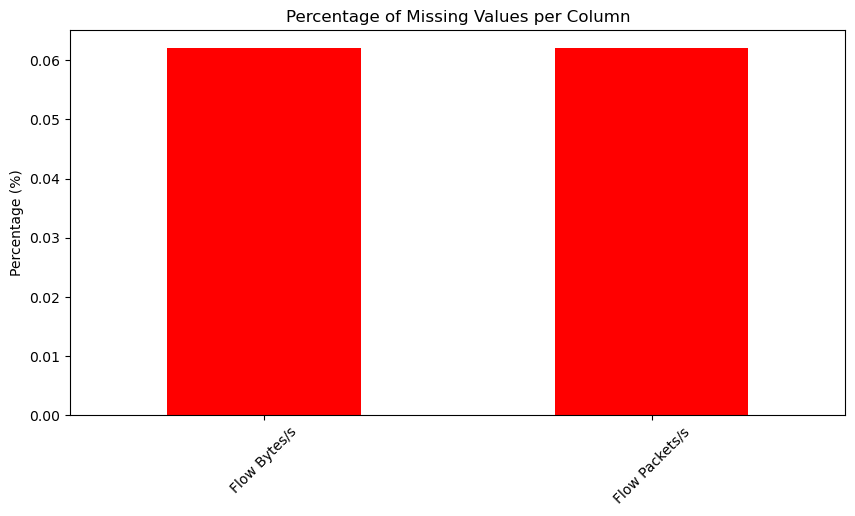

In [20]:
# Visualizing missing values per column
plt.figure(figsize=(10, 5))
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind="bar", color="red")
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()



>The analysis of missing values across the dataset suggests that missing values are not heavily concentrated in any single column and that the dataset can tolerate row-wise removal without significant impact.

### ***2.2.2. Row-wise Missing Value Analysis***

>Checking the distribution of missing values across rows.

In [21]:
# Checking row-wise missing value percentage
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print("Row-wise missing value statistics:")
display(row_missing_percentage.describe())  # Summary statistics for missing values per row

# Count total rows with at least one missing value
missing_rows = data.isna().any(axis=1).sum()
print(f" Total rows containing missing values: {missing_rows}")


Row-wise missing value statistics:


count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

 Total rows containing missing values: 1564


### ***2.2.3. Handling Missing Values***

>Following previous studies, such as Panigrahi and Borah (2018), and considering the minimal impact of removing rows with missing values (mostly concentrated in the Benign class), we will proceed with dropping these rows.

***Dropping Columns with Excessive Missing Values***

In [22]:
if not high_missing_cols.empty:
    data.drop(columns=high_missing_cols.index, inplace=True)
    print(f" Dropped {len(high_missing_cols)} columns with high missing values.")

***Dropping Rows with Missing Values***

In [23]:
# Drop rows with any missing values
data = data.dropna()
print(f"Final dataset shape after removing missing values: {data.shape}")


Final dataset shape after removing missing values: (2520798, 67)


### ***2.2.4. Garbage Collection (Memory Optimization)***

>To free up unused memory:

In [25]:
gc.collect()
print("Memory cleanup completed.")

Memory cleanup completed.


## ***2.3. Data-Driven Feature Selection***


>In this step, we remove **uninformative features** that contain only a **single unique value** across all rows. These features provide **no variance** and contribute nothing to machine learning models.

In [26]:
# Identify columns with only one unique value
unique_value_cols = [col for col in data.columns if data[col].nunique() == 1]

# Display results
print(" Columns with only one unique value:")
if unique_value_cols:
    display(unique_value_cols)
    print(f" Number of such columns: {len(unique_value_cols)}")
else:
    print(" No columns with a single unique value found.")


 Columns with only one unique value:


['Bwd PSH Flags']

 Number of such columns: 1


Columns with only a single unique value can typically be removed from the dataset before training machine learning models without risk of loss of relevant information.

In [27]:
# Drop these columns as they contribute no useful information
if unique_value_cols:
    data.drop(columns=unique_value_cols, inplace=True)
    print(" Columns with single unique values removed.")

# Checking new dataset shape after feature removal
print(f" Final dataset shape after feature selection: {data.shape}")

 Columns with single unique values removed.
 Final dataset shape after feature selection: (2520798, 66)


## ***2.4. Grouping & Removing Attack Types***



>The dataset categorizes attacks into different types, including various Denial of Service (DoS) attacks. To reduce class imbalance and enhance model training, attack types are grouped into broader categories.

### ***2.4.1. Grouping attack types***



>The table below illustrates the proposed grouping of attack categories. For now, DoS and DDoS will remain separate due to their distinct characteristics, such as differences in attack methodology and mitigation strategies, which could impact the model's performance and interpretation.




| **Group**                     | **Attack Type**             | **Count**  |  
|-------------------------------|-----------------------------|------------|  
| **Normal Traffic**            | BENIGN                      | 2,095,057  |  
|                               |                             | **Total: 2,095,057** |  
| **DoS Attacks**              | DoS Hulk                   | 172,846    |  
|                               | DoS GoldenEye               | 10,286     |  
|                               | DoS Slowloris               | 5,385      |  
|                               | DoS Slowhttptest            | 5,228      |
|                               |                             | **Total: 193,745** |
| **DDoS Attacks**              | DDoS                        | 128,014     |
|                               |                             | **Total: 128,014** |
| **Port Scanning**            | PortScan                    | 90,694     |  
|                               |                             | **Total: 90,694**  |  
| **Brute Force Attacks**      | FTP-Patator                 | 5,931      |  
|                               | SSH-Patator                 | 3,219      |  
|                               |                             | **Total: 9,150**   |  
| **Bots**                      | Bot                         | 1,948      |  
|                               |                             | **Total: 1,948**   |  
| **Web Attacks**              | Web Attack – Brute Force    | 1,470      |  
|                               | Web Attack – XSS            | 652        |  
|                               | Web Attack – SQL Injection   | 21         |  
|                               |                             | **Total: 2,143**   |  
| **Infiltration Attacks**     | Infiltration                | 36         |  
|                               |                             | **Total: 36**      |  
| **Miscellaneous**            | Heartbleed                  | 11         |  
|                               |                             | **Total: 11**      |

In [29]:
# Mapping attack types to broader categories
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',  
    'Web Attack � XSS': 'Web Attacks',          
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks', 
    'Heartbleed': 'Miscellaneous'
}

# Apply mapping
data['Attack Type'] = data['Label'].map(group_mapping)

# Handle unknown attack types
unknown_attacks = data['Label'][data['Attack Type'].isna()].unique()
if len(unknown_attacks) > 0:
    print("Warning: Some attack types were not in the mapping.")
    print("Unknown attack types:", unknown_attacks)
    # Instead of using inplace=True, use this approach to avoid the warning
    data['Attack Type'] = data['Attack Type'].fillna("Other Attacks")

# Display updated class distribution
attack_distribution = data['Attack Type'].value_counts()
print("\nUpdated Attack Type Distribution:")
print(attack_distribution)


Updated Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64


***Visualizing Attack Type Distribution***

>A bar chart helps visualize how attack types are distributed after grouping.

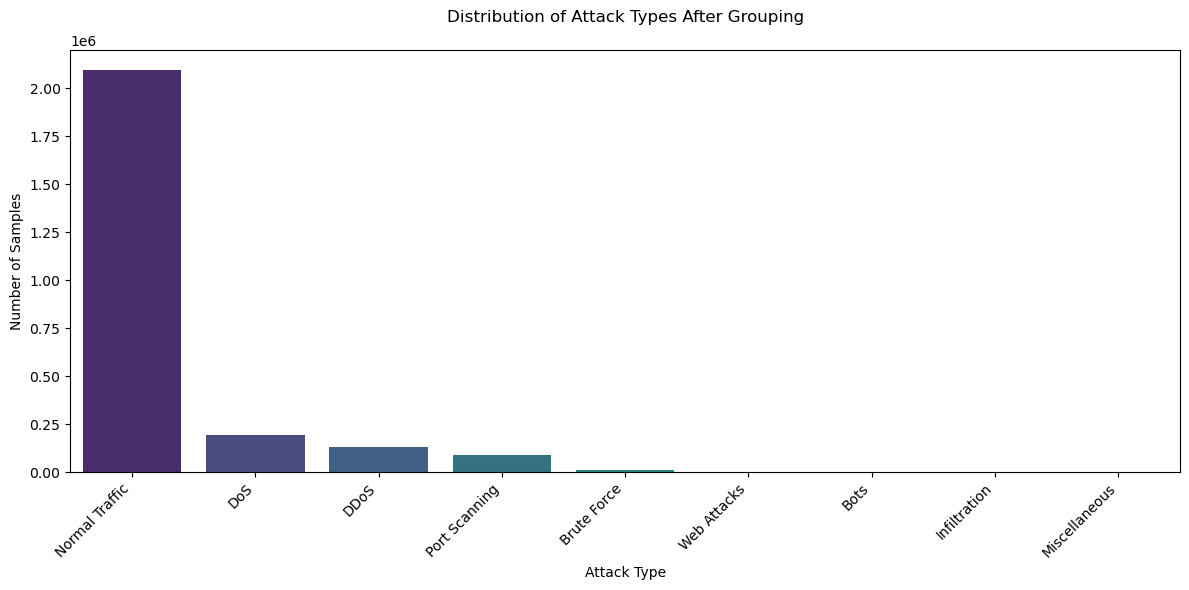

In [31]:
#  Visualization of attack type distribution


plt.figure(figsize=(12, 6))
sns.barplot(
    x=attack_distribution.index,
    y=attack_distribution.values,
    hue=attack_distribution.index,  # hue parameter
    legend=False,  
    palette="viridis"
)

# Improve readability
plt.title("Distribution of Attack Types After Grouping", pad=20, size=12)
plt.xlabel("Attack Type", size=10)
plt.ylabel("Number of Samples", size=10)

# Improve x-axis labels
plt.xticks(rotation=45, ha='right')  # Align rotated labels to the right
plt.tight_layout()  # Adjust layout to prevent label cutoff

plt.show()

***Dropping the Original Label Column***

>Since attack types are now grouped, the original `"Label"` column is no longer needed.

In [32]:
# Drop 'Label' column (no longer needed)
data.drop(columns=['Label'], inplace=True)
print(" 'Label' column dropped. Data is now grouped into attack types.")

# Final dataset shape
print(f"Final dataset shape after grouping attack types: {data.shape}")

 'Label' column dropped. Data is now grouped into attack types.
Final dataset shape after grouping attack types: (2520798, 66)


### ***2.4.2. Removing Rare Attack Types***

>Given the very low instance counts for 'Infiltration' (36) and 'Heartbleed' (11), it is advisable to remove these categories from the dataset as they can lead to overfitting and unreliable model performance, even techniques like SMOTE may not be sufficient to create a representative training sample.

In [39]:
# Define the threshold for removal (e.g., attacks with < 50 instances)
removal_threshold = 50

In [40]:
# Identify attack types with very low occurrences
attack_counts = data['Attack Type'].value_counts()
low_freq_attacks = attack_counts[attack_counts < removal_threshold].index.tolist()

In [41]:
# Display the attacks that will be removed
if low_freq_attacks:
    print("Attack types with very low occurrences (to be removed):")
    display(attack_counts[attack_counts < removal_threshold])
else:
    print(" No attack types found below the threshold.")

Attack types with very low occurrences (to be removed):


Attack Type
Infiltration     36
Miscellaneous    11
Name: count, dtype: int64

***Removing Low-Frequency Attack Types***

In [42]:
# Remove low-frequency attack types
data = data[~data['Attack Type'].isin(low_freq_attacks)]

# Print dataset shape after removal
print(f"\n Final dataset shape after removing low-frequency attacks: {data.shape}")



 Final dataset shape after removing low-frequency attacks: (2520751, 66)


***Visualizing Attack Distribution Before & After Removal***

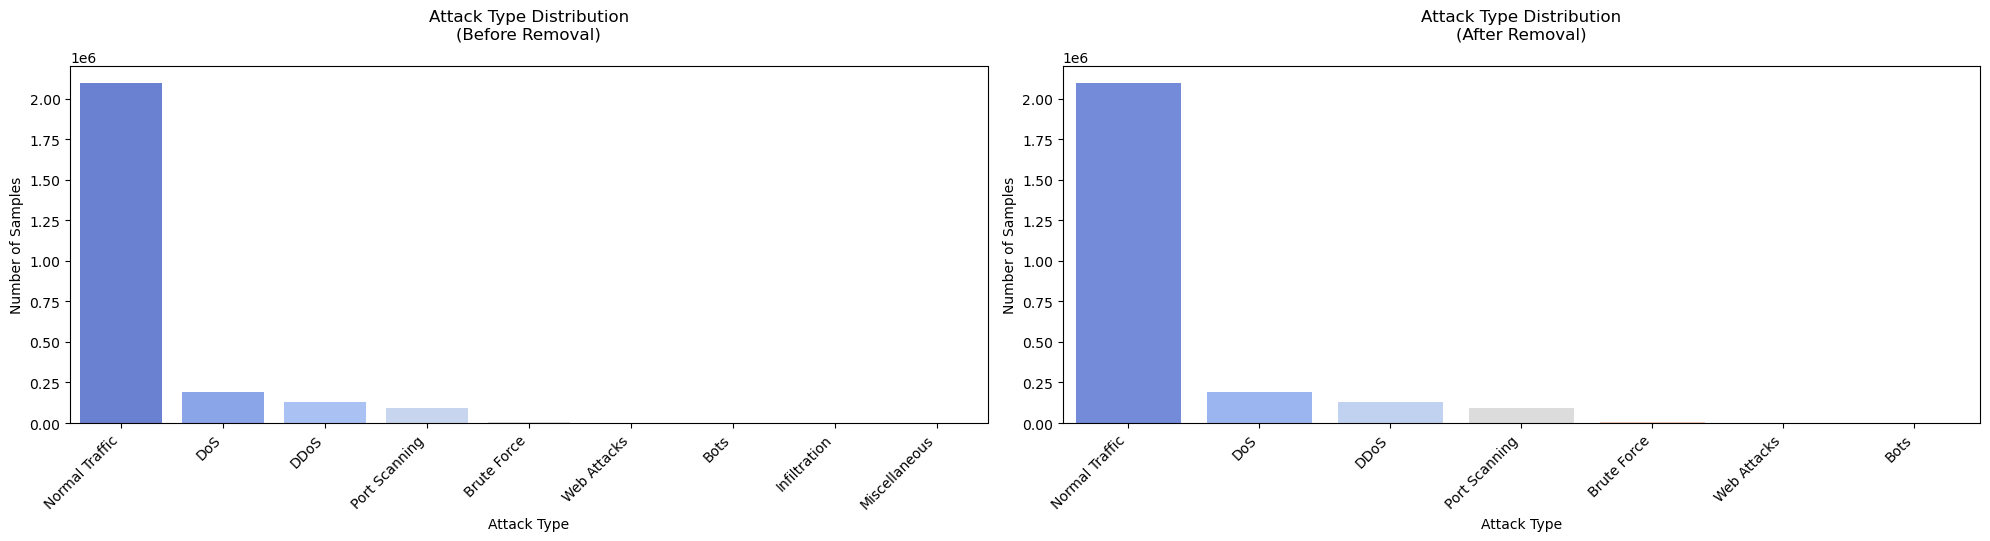


Numeric Comparison:
                   Before      After Difference  Change %
Attack Type                                              
Bots                1,948      1,948          0     0.00%
Brute Force         9,150      9,150          0     0.00%
DDoS              128,014    128,014          0     0.00%
DoS               193,745    193,745          0     0.00%
Infiltration           36          0        -36  -100.00%
Miscellaneous          11          0        -11  -100.00%
Normal Traffic  2,095,057  2,095,057          0     0.00%
Port Scanning      90,694     90,694          0     0.00%
Web Attacks         2,143      2,143          0     0.00%


In [48]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Before removal plot
sns.barplot(
    x=attack_counts.index,
    y=attack_counts.values,
    hue=attack_counts.index,
    legend=False,
    palette="coolwarm",
    ax=ax1
)
ax1.set_title("Attack Type Distribution\n(Before Removal)", pad=20, fontsize=12)
ax1.set_xlabel("Attack Type", fontsize=10)
ax1.set_ylabel("Number of Samples", fontsize=10)
# Fix rotation without warning
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# After removal plot
sns.barplot(
    x=attack_counts_after.index,
    y=attack_counts_after.values,
    hue=attack_counts_after.index,
    legend=False,
    palette="coolwarm",
    ax=ax2
)
ax2.set_title("Attack Type Distribution\n(After Removal)", pad=20, fontsize=12)
ax2.set_xlabel("Attack Type", fontsize=10)
ax2.set_ylabel("Number of Samples", fontsize=10)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlapping and add more bottom margin
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

# Print numeric comparison with improved formatting
print("\nNumeric Comparison:")
comparison_df = pd.DataFrame({
    'Before': attack_counts,
    'After': attack_counts_after
}).fillna(0)
comparison_df['Difference'] = comparison_df['After'] - comparison_df['Before']
comparison_df['Change %'] = (comparison_df['Difference'] / comparison_df['Before'] * 100).round(2)

# Format the numeric columns
for col in ['Before', 'After', 'Difference']:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:,.0f}")
comparison_df['Change %'] = comparison_df['Change %'].apply(lambda x: f"{x:.2f}%")

print(comparison_df)

# **3. Exploratory Data Analysis (EDA)**

>Exploratory Data Analysis (EDA) helps us **understand the dataset's structure**, **identify patterns**, and **detect potential issues** such as missing values, outliers, or highly correlated features.

## **3.1. Descriptive Statistics**

>First, we explore the dataset with **random samples** and **summary statistics** of numerical features.

In [49]:
print("Displaying random samples:")
display(data.sample(5))


Displaying random samples:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
2047667,53,226,2,2,78,110,39,39,39.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1972819,35890,28,1,1,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
670375,53,60819,1,1,64,117,64,64,64.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1916371,53,56115353,2,2,110,228,56,54,55.0,1.414214,...,20,47864.0,0.0,47864,47864,56000000.0,0.0,56000000,56000000,Normal Traffic
597377,443,6377011,10,12,1286,4939,469,0,128.6,186.252636,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic


In [50]:
print("Summary statistics of numerical features:")
display(data.describe())


Summary statistics of numerical features:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,...,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,...,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,...,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062000e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.332968e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [51]:
print(f"Initial dataset shape: {data.shape}")


Initial dataset shape: (2520751, 66)


## **3.2. Correlation Analysis**

>Why Correlation Analysis?
   - Identifies highly correlated features, which may introduce redundancy
   - Helps determine if dimensionality reduction (e.g., PCA) is necessary.
   - Guides feature selection by removing unnecessary variables.


In [52]:
def get_feature_types(df, exclude_target='Attack Type'):

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Ensure the target column is removed from both lists
    numeric_features = [col for col in numeric_features if col != exclude_target]
    categorical_features = [col for col in categorical_features if col != exclude_target]

    return numeric_features, categorical_features

In [53]:
#  Identify numerical and categorical features
numeric_features, categorical_features = get_feature_types(data)

print(f"Numeric features count: {len(numeric_features)}")
print(f"Categorical features count: {len(categorical_features)}")

Numeric features count: 65
Categorical features count: 0


### ***3.2.1. Computing the Correlation Matrix***

In [54]:
# Compute correlation matrix
correlation_matrix = data[numeric_features].corr()


### ***3.2.2. Detecting Highly Correlated Features***



>*   We define a correlation threshold of `0.95`.
*   Features that are highly correlated may be redundant and can be removed to avoid multicollinearity.



In [55]:
# Identify highly correlated features
correlation_threshold = 0.95  # Threshold for high correlation
high_corr_pairs = [
    (col, idx, correlation_matrix.loc[col, idx])
    for col in correlation_matrix.columns
    for idx in correlation_matrix.index
    if col != idx and abs(correlation_matrix.loc[col, idx]) > correlation_threshold
]

In [56]:
# Verify existing columns before analysis
existing_columns = set(data.columns)
filtered_high_corr_pairs = [(f1, f2, corr) for f1, f2, corr in high_corr_pairs if f1 in existing_columns and f2 in existing_columns]

# Warn about missing features (only if any are missing)
missing_features = set([f1 for f1, f2, _ in high_corr_pairs] + [f2 for f1, f2, _ in high_corr_pairs]) - existing_columns
if missing_features:
    print("Warning: The following features were expected in correlation analysis but are missing:")
    display(missing_features)

print("Highly Correlated Feature Pairs (Threshold > 0.95):")
if filtered_high_corr_pairs:
    for feature_x, feature_y, corr_value in filtered_high_corr_pairs:
        print(f" {feature_x} is highly correlated with {feature_y}: Corr={corr_value:.4f}")
else:
    print("No highly correlated feature pairs found.")




Highly Correlated Feature Pairs (Threshold > 0.95):
 Flow Duration is highly correlated with Fwd IAT Total: Corr=0.9985
 Total Fwd Packets is highly correlated with Total Backward Packets: Corr=0.9991
 Total Fwd Packets is highly correlated with Total Length of Bwd Packets: Corr=0.9970
 Total Fwd Packets is highly correlated with Subflow Bwd Bytes: Corr=0.9970
 Total Backward Packets is highly correlated with Total Fwd Packets: Corr=0.9991
 Total Backward Packets is highly correlated with Total Length of Bwd Packets: Corr=0.9945
 Total Backward Packets is highly correlated with Subflow Bwd Bytes: Corr=0.9944
 Total Length of Fwd Packets is highly correlated with Subflow Fwd Bytes: Corr=1.0000
 Total Length of Bwd Packets is highly correlated with Total Fwd Packets: Corr=0.9970
 Total Length of Bwd Packets is highly correlated with Total Backward Packets: Corr=0.9945
 Total Length of Bwd Packets is highly correlated with Subflow Bwd Bytes: Corr=1.0000
 Fwd Packet Length Max is highly co

### ***3.2.3. Visualizing Correlation Matrix***

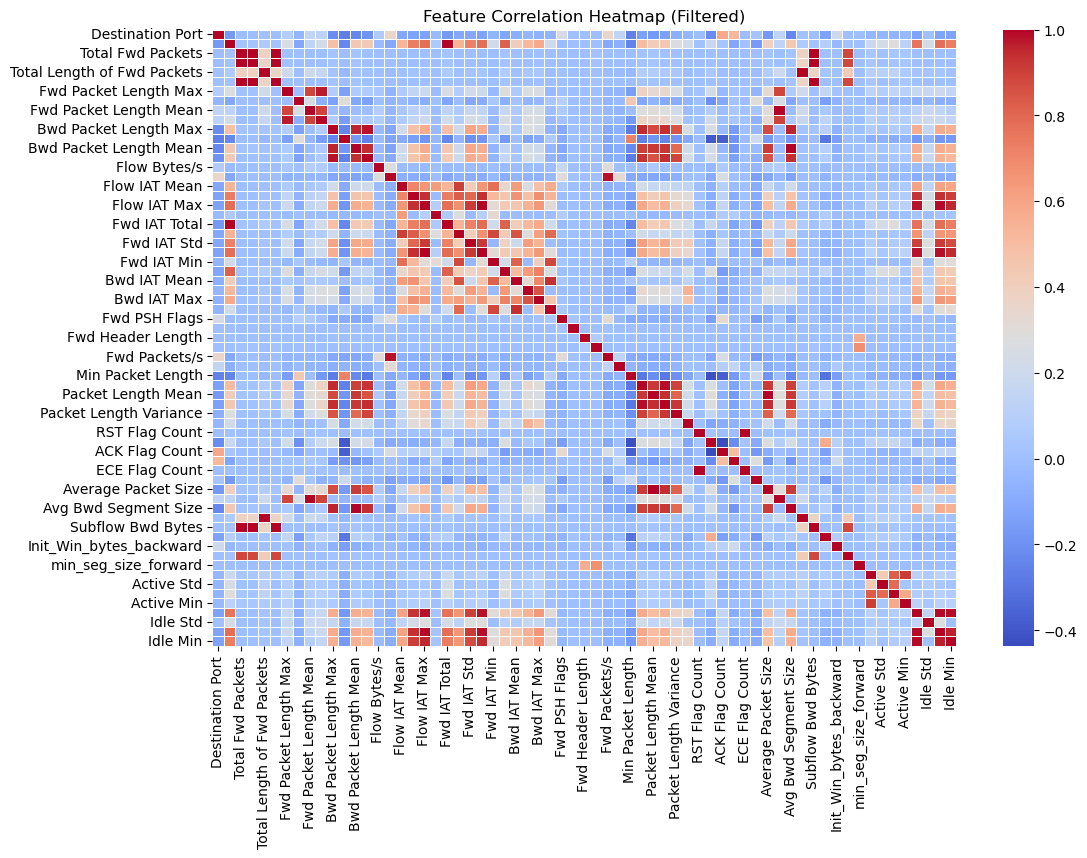

In [57]:

# Heatmap Visualization for Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap (Filtered)")
plt.show()

***Scatter Plot for Highly Correlated Feature Pairs***

>If there are highly correlated features, we visualize their relationship.

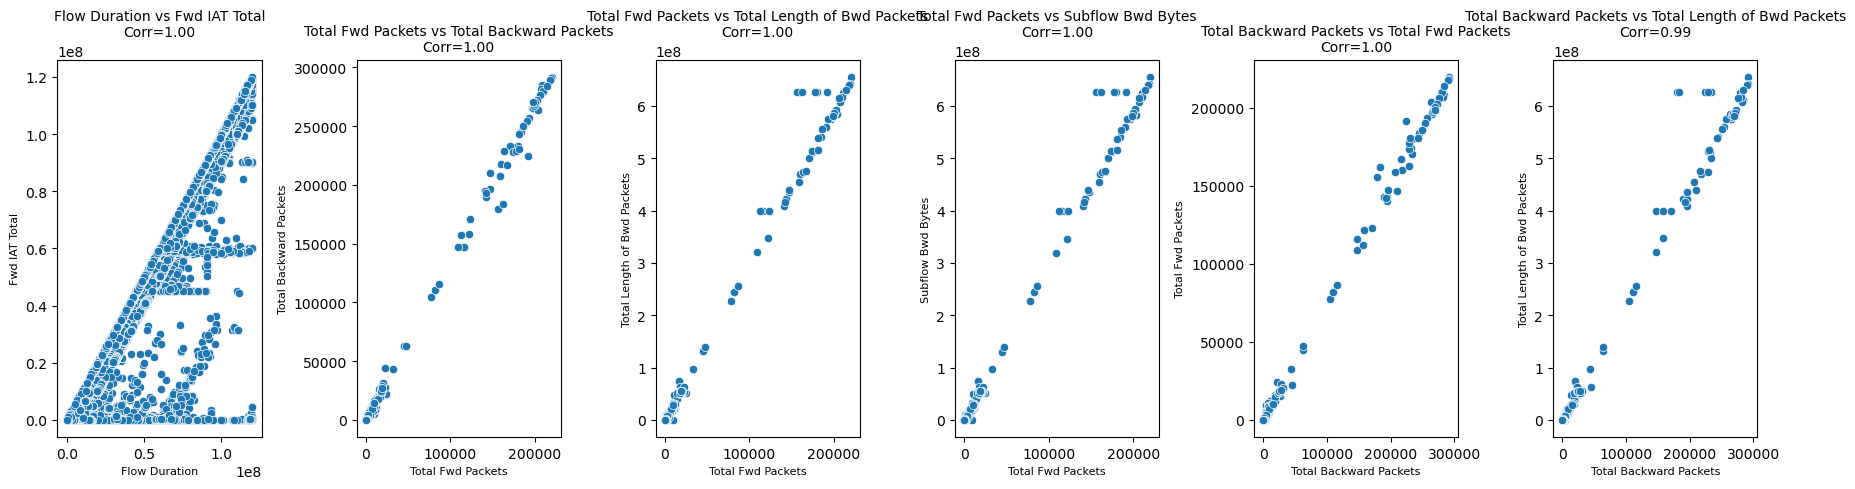

In [58]:
# Scatter Plot for Highly Correlated Feature Pairs
if filtered_high_corr_pairs:
    num_plots = min(len(filtered_high_corr_pairs), 6)  # Limit number of scatter plots for clarity
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 5))

    for i, (feature_x, feature_y, corr_value) in enumerate(filtered_high_corr_pairs[:num_plots]):
        sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
        axes[i].set_title(f'{feature_x} vs {feature_y}\nCorr={corr_value:.2f}', fontsize=10)
        axes[i].set_xlabel(feature_x, fontsize=8)
        axes[i].set_ylabel(feature_y, fontsize=8)

    plt.tight_layout()
    plt.show()


## **3.3. Removing Highly Correlated Features**

>Highly correlated features can be redundant, making the model more complex without improving accuracy. We automatically remove them.

In [59]:
# Automatically Drop Features with High Correlation
drop_candidates = list(set([pair[1] for pair in filtered_high_corr_pairs if pair[1] in existing_columns]))

if drop_candidates:
    print("Dropping the following highly correlated features:")
    display(drop_candidates)

    # Ensure only valid columns are dropped
    data.drop(columns=[col for col in drop_candidates if col in existing_columns], inplace=True)

    print("Highly correlated features removed.")
else:
    print(" No features were removed due to high correlation.")

Dropping the following highly correlated features:


['Idle Max',
 'Bwd Packet Length Mean',
 'Idle Mean',
 'ECE Flag Count',
 'Bwd Packet Length Std',
 'Idle Min',
 'RST Flag Count',
 'Fwd Packet Length Std',
 'Subflow Fwd Bytes',
 'Flow IAT Max',
 'Fwd IAT Total',
 'Fwd IAT Max',
 'Max Packet Length',
 'Total Fwd Packets',
 'Average Packet Size',
 'Subflow Bwd Bytes',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Bwd Packet Length Max',
 'Total Backward Packets',
 'Flow Packets/s',
 'Packet Length Std',
 'Fwd Packet Length Mean',
 'Avg Bwd Segment Size',
 'Total Length of Fwd Packets',
 'Fwd Packets/s',
 'Packet Length Mean',
 'Flow Duration',
 'Avg Fwd Segment Size']

Highly correlated features removed.


## **Final Dataset Shape After Feature Selection**

In [60]:
#Final dataset shape after cleaning

print(f"Final dataset shape after correlation-based feature selection: {data.shape}")

Final dataset shape after correlation-based feature selection: (2520751, 37)


# **4. Outliers**

>Outlier detection plays a crucial role in ensuring the quality and reliability of a dataset. Identifying features with significant deviations from the norm can help improve model accuracy by preventing skewed results.

Available numeric features:
['Destination Port', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s', 'Min Packet Length', 'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std']


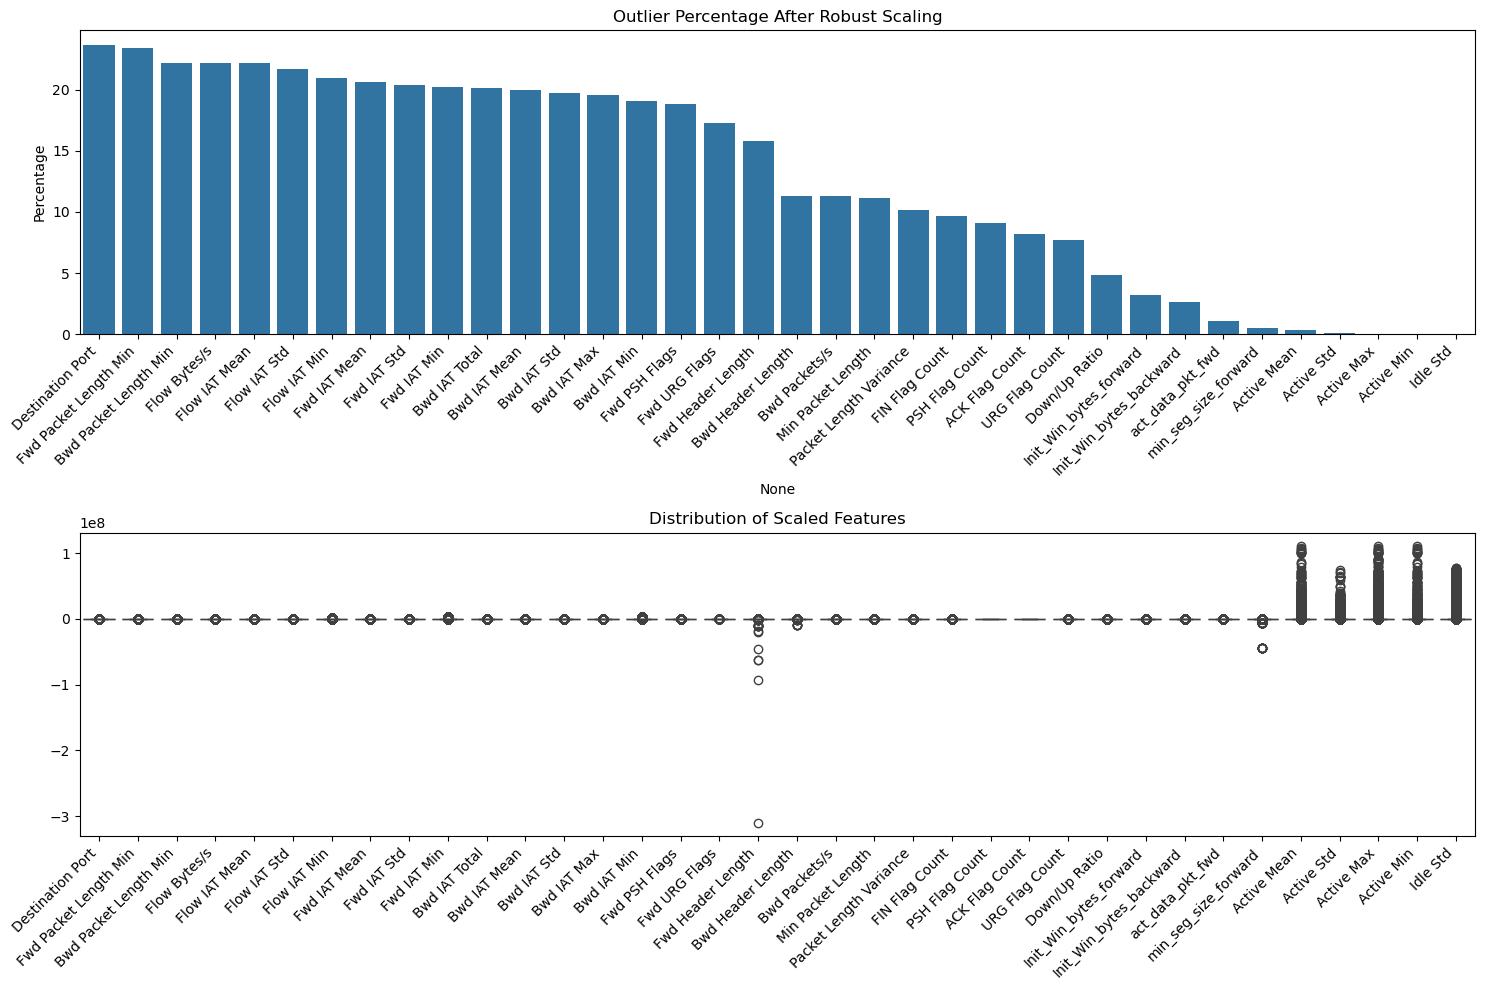

Features with more than 10% outliers after scaling:
Fwd IAT Std                23.657989
Bwd Packets/s              23.402391
Active Min                 22.167917
Active Max                 22.167917
Active Mean                22.167917
Destination Port           21.645137
Bwd IAT Total              20.926819
Bwd IAT Mean               20.602908
Fwd IAT Min                20.366311
Bwd IAT Max                20.187555
Fwd IAT Mean               20.126462
Flow IAT Mean              19.985512
Bwd IAT Std                19.700319
Packet Length Variance     19.538899
Flow IAT Min               19.072649
Flow Bytes/s               18.840576
Flow IAT Std               17.236332
Init_Win_bytes_forward     15.797475
Bwd IAT Min                11.292230
Init_Win_bytes_backward    11.276124
Fwd Header Length          11.120218
URG Flag Count             10.139439
Name: outlier_percentage, dtype: float64
Features recommended for log transformation:
['Destination Port', 'Flow Bytes/s', 'Flow IAT M

In [61]:
# Update numeric feature list
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Attack Type' in numeric_features:
    numeric_features.remove('Attack Type')

print("Available numeric features:")
print(numeric_features)

def preprocess_and_analyze_outliers(data, numeric_features):
    """
    Preprocess data and analyze outliers using RobustScaler.
    """
    # Initialize RobustScaler
    scaler = RobustScaler()

    # Scale data
    scaled_data = pd.DataFrame(
        scaler.fit_transform(data[numeric_features]),
        columns=numeric_features
    )

    # Compute outliers using IQR method
    outliers_info = {}
    for col in scaled_data.columns:
        # Calculating outliers with the IQR method for scaled data
        Q1 = scaled_data[col].quantile(0.25)
        Q3 = scaled_data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((scaled_data[col] < (Q1 - 1.5 * IQR)) |
                   (scaled_data[col] > (Q3 + 1.5 * IQR))).sum()
        outliers_info[col] = {
            'outlier_count': outliers,
            'outlier_percentage': (outliers / len(scaled_data)) * 100,
            'mean': scaled_data[col].mean(),
            'std': scaled_data[col].std()
        }

    # Convert to DataFrame
    outliers_df = pd.DataFrame.from_dict(outliers_info, orient='index')

    # Visualizing results
    plt.figure(figsize=(15, 10))

    # Bar plot for outlier percentage
    plt.subplot(2, 1, 1)
    sns.barplot(data=outliers_df.sort_values('outlier_percentage', ascending=False),
                x=outliers_df.index,
                y='outlier_percentage')
    plt.xticks(rotation=45, ha='right')
    plt.title('Outlier Percentage After Robust Scaling')
    plt.ylabel('Percentage')

    # Boxplot of scaled features
    plt.subplot(2, 1, 2)
    sns.boxplot(data=scaled_data)
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Scaled Features')

    plt.tight_layout()
    plt.show()

    # Identifying features with high outliers
    threshold = 10
    high_outliers = outliers_df[outliers_df['outlier_percentage'] > threshold]
    print(f"Features with more than {threshold}% outliers after scaling:")
    print(high_outliers['outlier_percentage'].sort_values(ascending=False))

    return scaled_data, outliers_df

# Execute function
scaled_data, outliers_info = preprocess_and_analyze_outliers(data, numeric_features)

# Features recommended for log transformation
high_outlier_features = outliers_info[outliers_info['outlier_percentage'] > 15].index.tolist()
print("Features recommended for log transformation:")
print(high_outlier_features)

# **5. Data Distribution & Class Imbalance**

Understanding the distribution of the data is fundamental for selecting the right preprocessing and modeling techniques. Data distribution also gives insights towards the best statistic tests to perform.

In [62]:

# Normality Test
print("Data Distribution Analysis:")

norm_dist = 0
not_norm_dist = 0
normality_results = {}

for col in numeric_features:
    # Perform Anderson-Darling test for normality
    result = stats.anderson(data[col], dist='norm')

    # Store results for later reference
    normality_results[col] = result.statistic

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

# Display summary of normality tests
print(f" {norm_dist} features appear to be normally distributed.")
print(f" {not_norm_dist} features do NOT follow normal distribution (Reject Null Hypothesis).")




Data Distribution Analysis:
 0 features appear to be normally distributed.
 36 features do NOT follow normal distribution (Reject Null Hypothesis).


## **5.1. Class Imbalance Analysis**

In [63]:
print("Class Imbalance Analysis:")

# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Calculate total occurrences
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Compute percentage of each class
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

# Display attack type distribution
display(attack_counts_df)


Class Imbalance Analysis:


,Attack Type,Number of Occurrences,% of Total
0,Normal Traffic,2095057,83.11
1,DoS,193745,7.69
2,DDoS,128014,5.08
3,Port Scanning,90694,3.60
4,Brute Force,9150,0.36
5,Web Attacks,2143,0.09
6,Bots,1948,0.08


## **5.2. Visualization of Class Distribution**

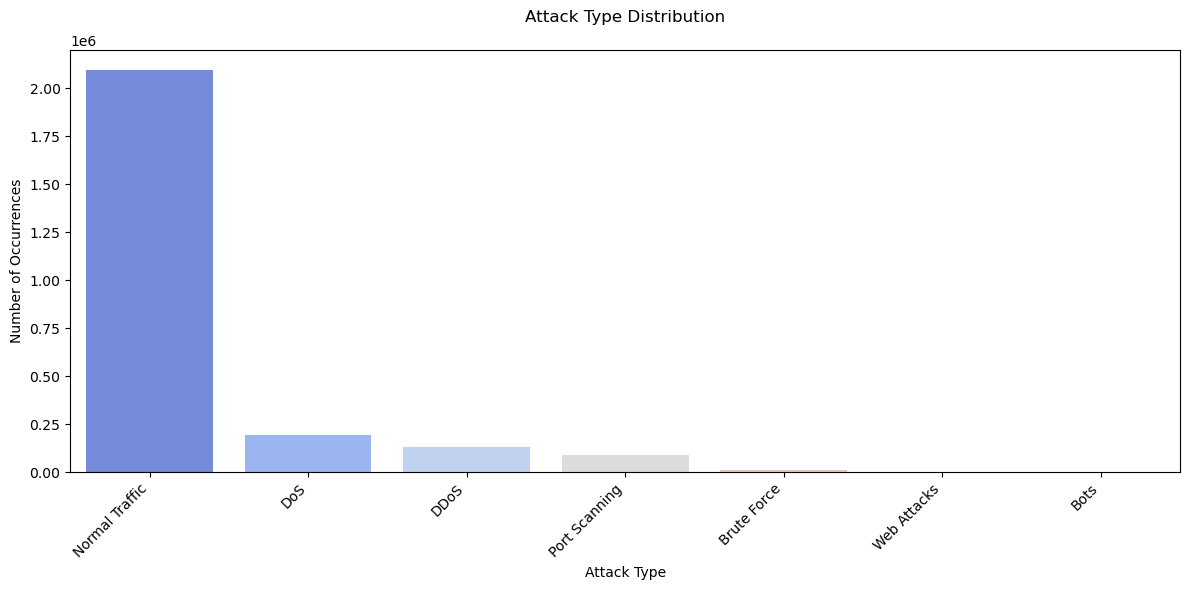

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=attack_counts_df, 
    x="Attack Type", 
    y="Number of Occurrences",
    hue="Attack Type",  # Add hue parameter
    legend=False,       # Hide redundant legend
    palette="coolwarm"
)

# Improve title and labels
plt.title("Attack Type Distribution", pad=20, fontsize=12)
plt.xlabel("Attack Type", fontsize=10)
plt.ylabel("Number of Occurrences", fontsize=10)

# Improve x-axis label readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## **5.3. Observations on Class Imbalance**

In [66]:
print("Observations on Class Imbalance:")
dominant_class = attack_counts_df.iloc[0]['Attack Type']
dominant_class_pct = attack_counts_df.iloc[0]['% of Total']

print(f" The '{dominant_class}' class dominates the dataset, making up {dominant_class_pct}% of the total.")
print(" Some attack types have very low representation, which may cause model bias.")


Observations on Class Imbalance:
 The 'Normal Traffic' class dominates the dataset, making up 83.11% of the total.
 Some attack types have very low representation, which may cause model bias.


# **6. Feature Importance Analysis**



> Feature importance analysis helps us understand which features contribute most to the prediction of different attack types. We use both statistical tests (Kruskal-Wallis test) and machine learning models (Random Forest) to rank the importance of each feature.



## **6.1. Kruskal-Wallis Test for Feature Importance**

>The Kruskal-Wallis test is a non-parametric statistical test that determines whether different groups (attack types) have significantly different distributions for a given feature. Features with higher H-statistic values are considered more relevant.



Performing Kruskal-Wallis test for feature importance...

Kruskal-Wallis test completed for 36 features.

Top 10 most important features based on H-statistic:
                   Feature    H-statistic  p-value
8              Fwd IAT Std  636060.304071      0.0
7             Fwd IAT Mean  592885.051978      0.0
5             Flow IAT Std  583436.800056      0.0
4            Flow IAT Mean  524746.801923      0.0
22          FIN Flag Count  500318.644205      0.0
19           Bwd Packets/s  452485.894562      0.0
21  Packet Length Variance  373845.434316      0.0
12             Bwd IAT Std  351480.669309      0.0
17       Fwd Header Length  341947.780347      0.0
2    Bwd Packet Length Min  319130.563542      0.0


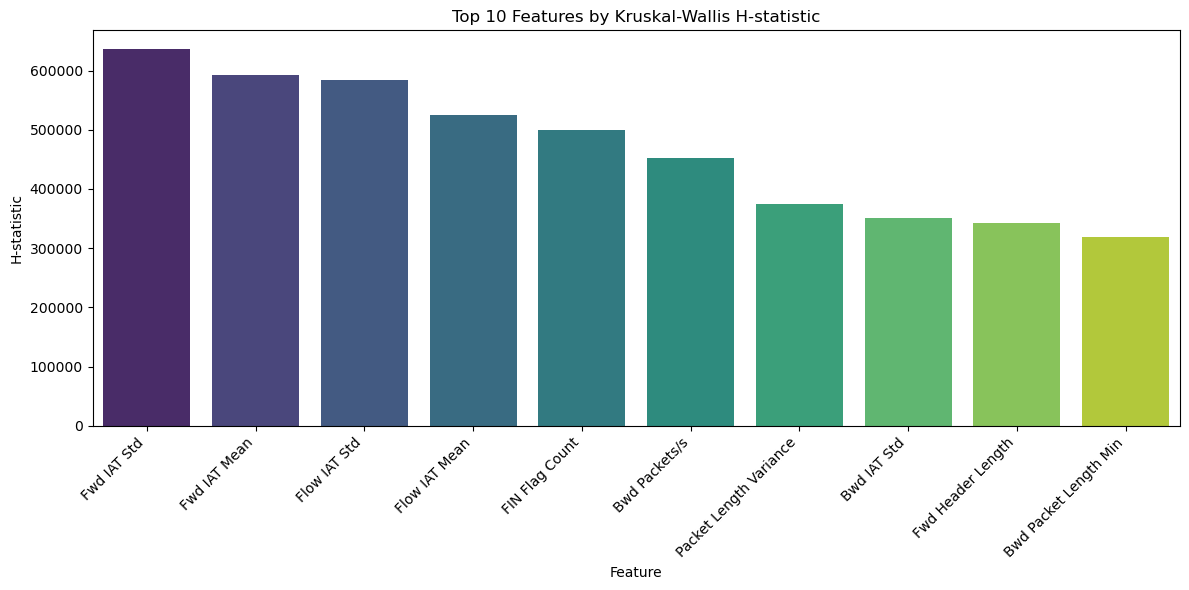

In [70]:
# First, identify numeric features from your dataset
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove the target variable if it's numeric
numeric_features = [feat for feat in numeric_features if feat != 'Attack Type']

print("Performing Kruskal-Wallis test for feature importance...")
kruskal_results = {}

# Perform Kruskal-Wallis test for each numeric feature
for feature in numeric_features:
    try:
        # Create groups based on Attack Type
        groups = [data[feature][data['Attack Type'] == label] for label in data['Attack Type'].unique()]
        # Perform Kruskal-Wallis H-test
        stat, p_value = kruskal(*groups)
        kruskal_results[feature] = {'H-statistic': stat, 'p-value': p_value}
    except Exception as e:
        print(f"Error processing feature {feature}: {str(e)}")

# Convert results into a DataFrame
h_p_stats = pd.DataFrame.from_dict(kruskal_results, orient='index')
h_p_stats.reset_index(inplace=True)
h_p_stats.rename(columns={'index': 'Feature'}, inplace=True)

# Sort by H-statistic in descending order to see most important features first
h_p_stats = h_p_stats.sort_values('H-statistic', ascending=False)

print(f"\nKruskal-Wallis test completed for {len(numeric_features)} features.")
print("\nTop 10 most important features based on H-statistic:")
print(h_p_stats.head(10))

# Optionally, visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(
    data=h_p_stats.head(10),  # Top 10 features
    x='Feature',
    y='H-statistic',
    hue='Feature',
    legend=False,
    palette='viridis'
)
plt.title('Top 10 Features by Kruskal-Wallis H-statistic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **6.2. Random Forest Feature Importance**

>We train a Random Forest classifier to determine feature importance based on model-based ranking.

Training Random Forest model for feature importance...
Dataset split successful. Using 36 features.
Random Forest training completed.

Top 10 most important features:
                    Feature  Importance
0          Destination Port    0.145123
28  Init_Win_bytes_backward    0.110552
18        Bwd Header Length    0.067431
21   Packet Length Variance    0.055049
27   Init_Win_bytes_forward    0.054128
3              Flow Bytes/s    0.053578
17        Fwd Header Length    0.047660
7              Fwd IAT Mean    0.041415
19            Bwd Packets/s    0.041358
8               Fwd IAT Std    0.038541


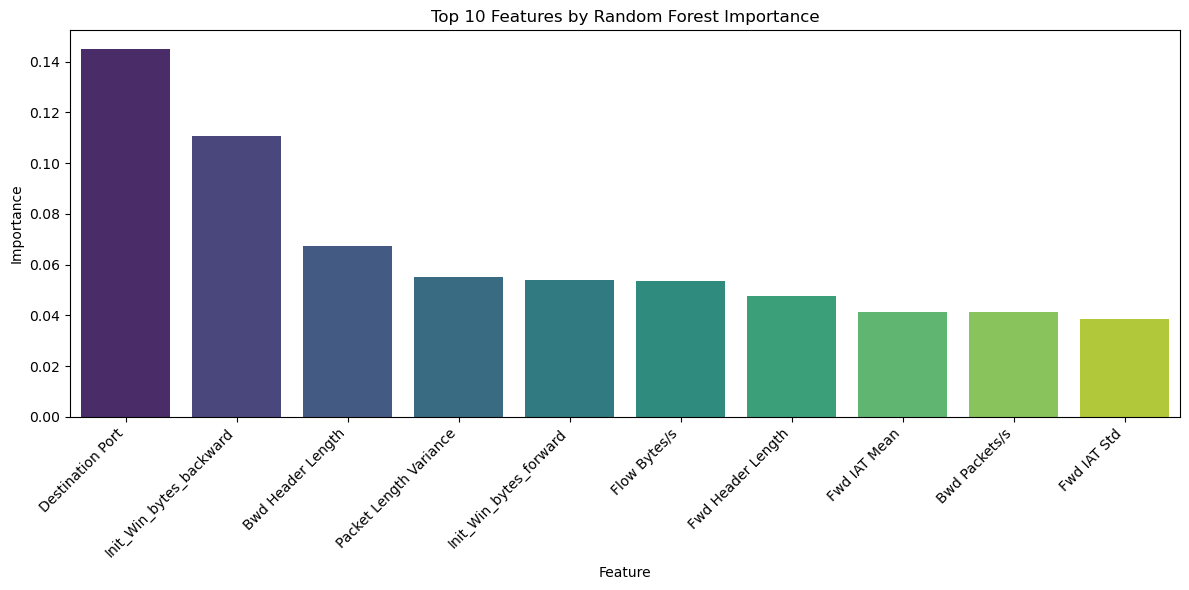

In [72]:
print("Training Random Forest model for feature importance...")

# Get numeric features from the dataset
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove the target variable if it's in numeric features
numeric_features = [feat for feat in numeric_features if feat != 'Attack Type']

# Encode target variable
data_encoded = data.copy()
data_encoded['Attack Type'] = data_encoded['Attack Type'].astype('category').cat.codes

# Split dataset into training and test sets
X = data_encoded[numeric_features]
y = data_encoded['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dataset split successful. Using {len(numeric_features)} features.")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Compute feature importance
feature_importance_tree = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': rf.feature_importances_
})
feature_importance_tree = feature_importance_tree.sort_values(by='Importance', ascending=False)

print("Random Forest training completed.")

# Display top 10 most important features
print("\nTop 10 most important features:")
print(feature_importance_tree.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(
    data=feature_importance_tree.head(10),
    x='Feature',
    y='Importance',
    hue='Feature',
    legend=False,
    palette='viridis'
)
plt.title('Top 10 Features by Random Forest Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **6.3. Model Performance Evaluation**

>After training, we evaluate the classification performance using a confusion matrix and classification report.

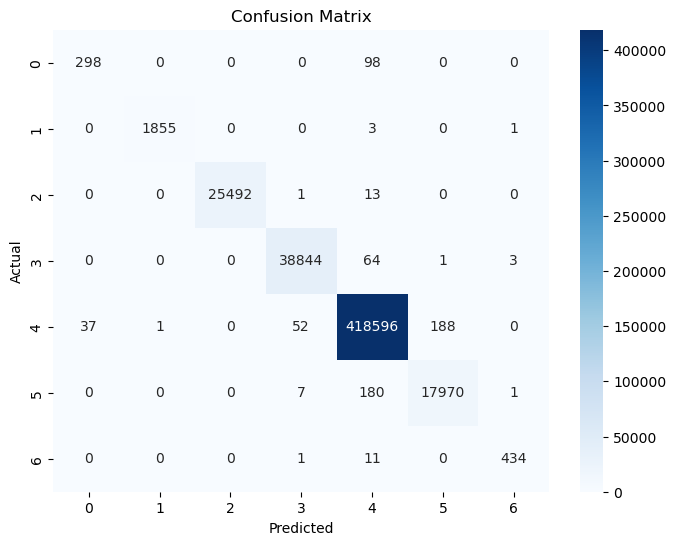

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82       396
           1       1.00      1.00      1.00      1859
           2       1.00      1.00      1.00     25506
           3       1.00      1.00      1.00     38912
           4       1.00      1.00      1.00    418874
           5       0.99      0.99      0.99     18158
           6       0.99      0.97      0.98       446

    accuracy                           1.00    504151
   macro avg       0.98      0.96      0.97    504151
weighted avg       1.00      1.00      1.00    504151



In [73]:
# Predict on test set
y_pred = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

## **6.4. Comparing Kruskal-Wallis and Random Forest Feature Importance**

>We compare the feature importance scores from both Random Forest and Kruskal-Wallis tests.

In [74]:
print("Comparing Random Forest and Kruskal-Wallis Feature Rankings...")

comparison_tb = feature_importance_tree.merge(h_p_stats, on="Feature", how="left")
comparison_tb_sorted = comparison_tb.sort_values(by="Importance", ascending=False)


Comparing Random Forest and Kruskal-Wallis Feature Rankings...


***Visualizing Feature Importance***

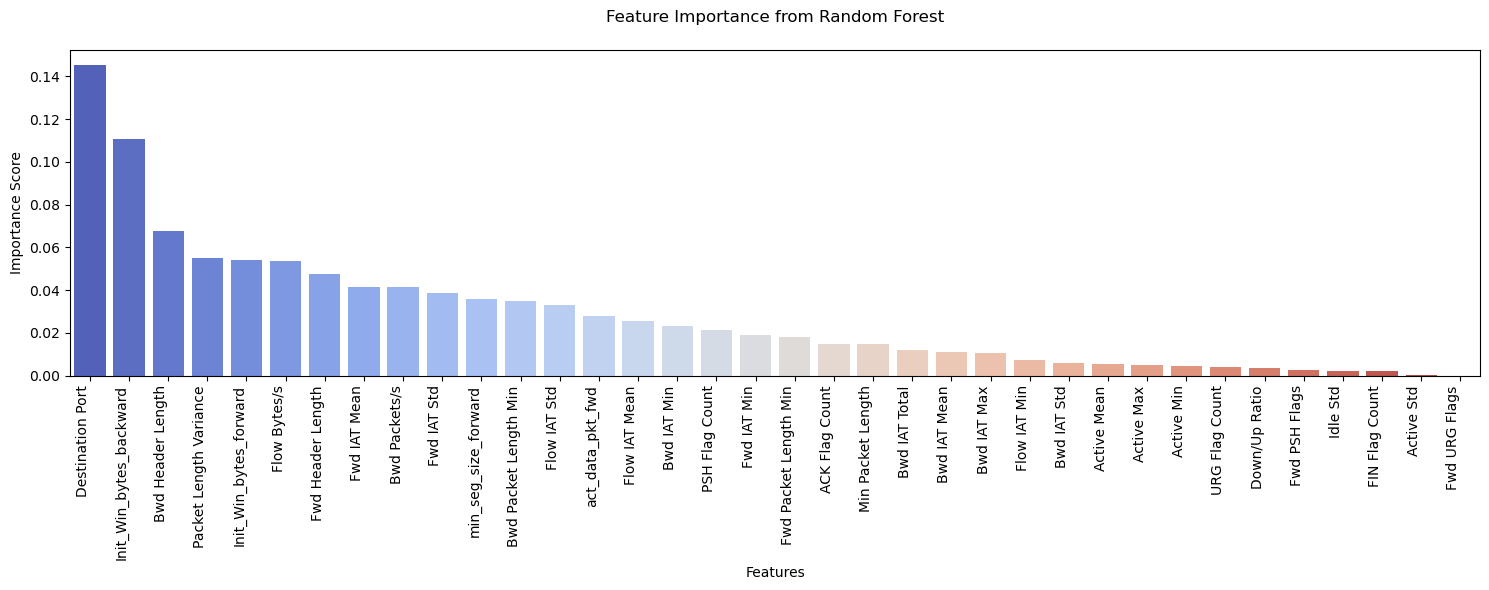

In [76]:
plt.figure(figsize=(15, 6))
sns.barplot(
    data=comparison_tb_sorted,
    x="Feature",
    y="Importance",
    hue="Feature",  
    legend=False,  
    palette="coolwarm"
)

# Improve readability
plt.title("Feature Importance from Random Forest", pad=20, fontsize=12)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Importance Score", fontsize=10)

plt.xticks(rotation=90, ha='right')

plt.tight_layout()

plt.show()

## **6.5. Removing Statistically Irrelevant Features**

>Some features contribute very little to model performance and can be removed to improve training efficiency.

In [77]:
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std',
                  'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']

# Ensure only existing columns are dropped
existing_cols_to_remove = [col for col in cols_to_remove if col in data.columns]

if existing_cols_to_remove:
    print(f"Removing {len(existing_cols_to_remove)} low-importance features...")
    data.drop(columns=existing_cols_to_remove, inplace=True)
    print(f"Feature removal complete. Final dataset shape: {data.shape}")
else:
    print("No matching columns found for removal. Dataset remains unchanged.")



Removing 6 low-importance features...
Feature removal complete. Final dataset shape: (2520751, 31)


## **6.6. Handling Imbalanced Data with SMOTE**

>Since the dataset has class imbalance, we apply SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples for underrepresented classes.

In [78]:

def balanced_sampling_multiclass(X, y):
    """
    Apply SMOTE to balance class distribution in a multi-class dataset.
    """
    # Calculating the sampling strategy
    counter = Counter(y)
    max_class_count = max(counter.values())

    # Adjust strategy to balance minority classes without oversampling the largest class
    strategy = {class_label: max_class_count // 2
               for class_label in counter.keys()
               if counter[class_label] < max_class_count}

    # Apply SMOTE
    smote = SMOTE(sampling_strategy=strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))

    return X_resampled, y_resampled


## **6.7. Optimized Random Forest Training**

>After applying SMOTE, we retrain the Random Forest classifier with optimized hyperparamet

In [79]:
def train_optimized_rf(X_train, y_train):
    """
    Train an optimized Random Forest classifier with balanced data.
    """
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    return rf



## **6.8. Full Feature Importance Pipeline**

>This function runs the complete feature selection and importance analysis pipeline.

In [80]:
def main_analysis(data, numeric_features):
    print(" Starting optimized analysis...")

    # Prepare dataset
    X = data[numeric_features]
    y = data['Attack Type']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("Balancing dataset...")
    X_train_balanced, y_train_balanced = balanced_sampling_multiclass(X_train, y_train)

    print("Training Random Forest...")
    rf = train_optimized_rf(X_train_balanced, y_train_balanced)

    # Evaluate model
    y_pred = rf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute feature importance
    feature_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

    return rf, feature_importance



## **6.9. Running the Feature Analysis Pipeline**

>This section initializes the feature importance analysis by identifying numerical features, removing the target variable (Attack Type), and executing the main_analysis() function.

In [81]:
numeric_features = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
if 'Attack Type' in numeric_features:
    numeric_features.remove('Attack Type')

# Running the feature analysis pipeline
model, importance = main_analysis(data, numeric_features)

 Starting optimized analysis...
Balancing dataset...
Original class distribution: Counter({'Normal Traffic': 1676045, 'DoS': 154996, 'DDoS': 102411, 'Port Scanning': 72555, 'Brute Force': 7320, 'Web Attacks': 1714, 'Bots': 1559})
Resampled class distribution: Counter({'Normal Traffic': 1676045, 'DoS': 838022, 'Port Scanning': 838022, 'DDoS': 838022, 'Brute Force': 838022, 'Bots': 838022, 'Web Attacks': 838022})
Training Random Forest...
Classification Report:
                precision    recall  f1-score   support

          Bots       0.10      0.99      0.19       389
   Brute Force       0.96      1.00      0.98      1830
          DDoS       0.96      1.00      0.98     25603
           DoS       0.98      1.00      0.99     38749
Normal Traffic       1.00      0.99      0.99    419012
 Port Scanning       0.99      1.00      0.99     18139
   Web Attacks       0.79      1.00      0.88       429

      accuracy                           0.99    504151
     macro avg       0.83     

## **6.10. Interpretation of Feature Importance Analysis**

>After completing both the Kruskal-Wallis test and the Random Forest feature importance analysis, we can now interpret the results and discuss their implications for feature selection.

### ***6.10.1. Justification for Using Kruskal-Wallis Instead of One-Way ANOVA***

>The previous statistical evaluation revealed that only three features failed to reject the null hypothesis (i.e., their distributions across attack types were not significantly different). This finding, combined with the information on data distribution, suggests that One-Way ANOVA is not a suitable test for our dataset.

>A better alternative is the Kruskal-Wallis test, a non-parametric test that:
  - Does not assume normality or equal variances (homoscedasticity).
  - Is robust to violations of normality, making it well-suited for our dataset.
  
   
  >Using this approach, we obtained H-statistic values that provided a ranking of feature importance based on statistical significance.

### ***6.10.2. Understanding Feature Importance in Random Forests***

> Now that we have the results from the Kruskal-Wallis test, we proceeded to train a Random Forest model and analyze its feature importance scores.
</br> Unlike Kruskal-Wallis, which evaluates statistical differences, Random Forests assess feature importance based on their contribution to model performance.

> **How Random Forest Calculates Feature Importance:**
  - It evaluates how much each feature reduces impurity (e.g., Gini impurity or entropy) when making splits in decision trees.
  - Features that appear higher in the tree or in more trees are considered more influential.
  - The overall importance score is computed across all trees in the forest.
  
  >Thus, Random Forest provides a machine learning-based perspective on feature relevance, allowing us to compare its rankings with the statistical rankings from Kruskal-Wallis.

### ***6.10.3. Observations from the Random Forest Model Performance***

>After training and evaluating the Random Forest classifier, we observed strong overall performance in predicting attack types. However, some misclassification issues emerged, particularly with Bot attacks.

>**Key Observations from the Confusion Matrix and Classification Report:**
  - Overall accuracy was high, confirming that the selected features contribute well to classification.
  - Bot attacks were frequently misclassified as normal traffic (~25% misclassification rate).
  - This issue arises due to class imbalance (Bot attacks being a minority class).

> **Implications of Bot Attack Misclassification:**
1.   The current feature set may not be optimized for detecting Bots
2.   The current feature set may not be optimized for detecting Bots
3.   Class balancing techniques (e.g., SMOTE, oversampling) could improve detection performance.
4.   Considering alternative models or hybrid approaches (e.g., anomaly detection + classification models) may be beneficial.

>Despite this limitation, the Random Forest feature importance scores remain valuable for guiding feature selection, especially when compared to the Kruskal-Wallis H-statistic.

### ***6.10.4. Conclusion & Next Steps in Feature Selection***



>*   The Kruskal-Wallis test helped rank features based on statistical differences across attack types.
*   The Random Forest model provided an ML-driven ranking based on predictive contributions.
*   Comparing both approaches allows us to make an informed feature selection decision.
*   Addressing class imbalance and refining feature engineering could further improve intrusion detection performance.

>**Next Step:**
  <br/> Use the combined insights from Kruskal-Wallis and Random Forest to select the most informative features and remove irrelevant ones, ensuring a leaner, more effective feature set for the final intrusion detection model.

### ***Final Thought:***

>This analysis highlights the importance of combining statistical and machine learning approaches in feature selection. By leveraging both perspectives, we can build a more robust and interpretable intrusion detection model.

## **6.11. Feature Selection and Final Feature Set**

>After conducting both statistical (Kruskal-Wallis test) and machine learning-based (Random Forest) feature importance analysis, we have selected the most relevant features for our final dataset. The goal of this selection process is to improve model efficiency, reduce noise, and enhance interpretability.

### ***6.11.1. Visualizing Feature Importance and H-Statistic***

>The following plot provides a comparative view of feature importance as determined by Random Forest and the Kruskal-Wallis test.

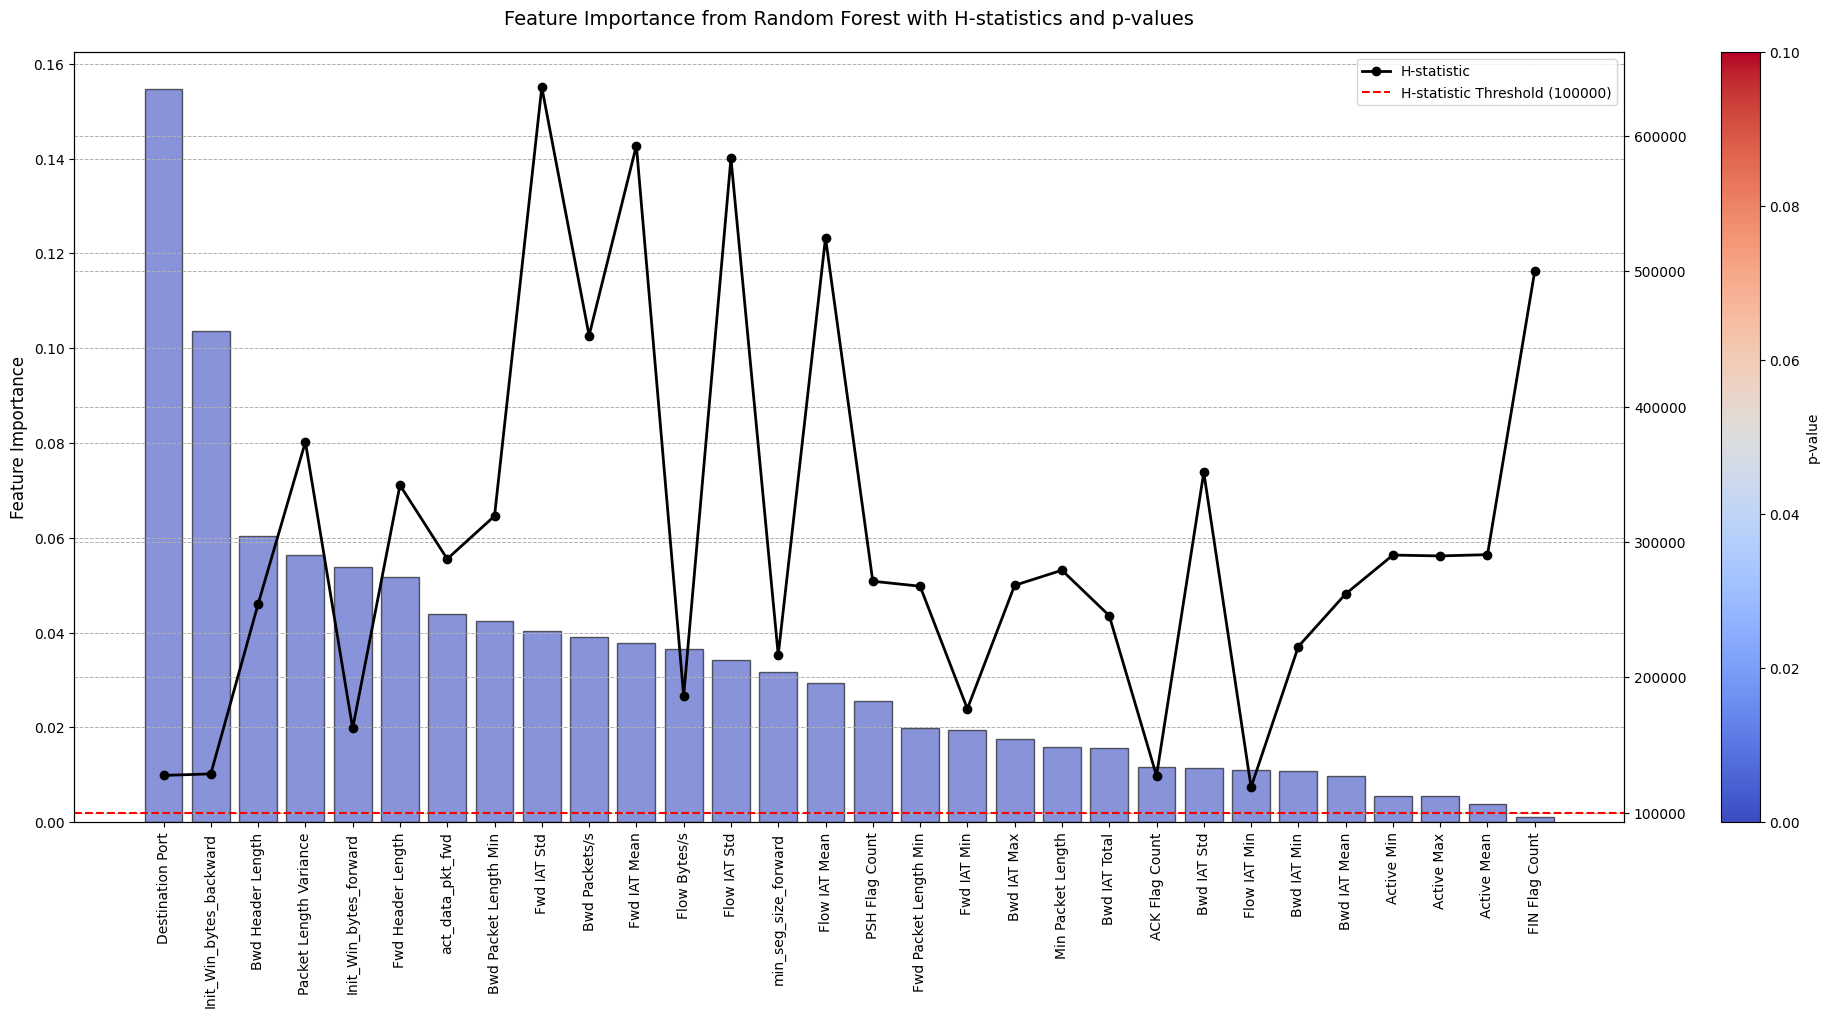

In [ ]:
# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()


### ***6.11.2. Key Takeaways from the Feature Importance Analysis***

>**The plot illustrates that:**
  - Some features highly ranked by Random Forest have lower H-statistics, suggesting that they are useful in a machine learning model but not necessarily statistically significant.
  - The most important features are clustered where the highest H-statistics are concentrated, indicating strong statistical relevance.
  - Features in the rightmost section of the plot have low H-statistics and importance, meaning they can be removed without significant performance loss.

>**Why remove less important features?**
- Improved Model Efficiency: Reducing feature count lowers computational costs (memory and training time).
- Reduced Noise: Eliminating irrelevant features prevents overfitting.
- Simplified Interpretation: A model with fewer features is easier to analyze and explain.

The plot illustrates that while some features selected by the Random Forest (RF) have lower H-statistics, the most significant features are found within the range where the highest H-statistic values are concentrated. The most interesting information, however, lies on the right tail, where there is a convergence on the lowest priority and near-zero H-statistic relevance. Based on these results, the least important features will be removed from the dataset, which helps with:

 * Improving Model Efficiency: Training with fewer features reduces computational cost (time and memory).
 * Reducing Noise: Removing irrelevant features can sometimes improve model performance by reducing noise and preventing overfitting.
 * Simplifying Interpretation: Models with fewer features are often easier to interpret and explain.

## **6.12. Final Selected Features**

>Based on the combined analysis of Kruskal-Wallis and Random Forest rankings, the following features have been retained in the final dataset:

***Overview of the Final Columns***

| **Column Name**                    | **Description**                                                                                                                                             |
|-------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Destination Port                    | The destination port for the flow.                                                                                                                         |
| Flow Duration                       | The duration of the flow.                                                                                                                                   |
| Total Fwd Packets                   | The total number of forwarded packets in the flow.                                                                                                         |
| Total Length of Fwd Packets         | The total length of forwarded packets in the flow.                                                                                                         |
| Fwd Packet Length Max               | The maximum size of forwarded packets.                                                                                                                      |
| Fwd Packet Length Min               | The minimum size of forwarded packets.                                                                                                                     |
| Fwd Packet Length Mean              | The average length of forwarded packets in the flow.                                                                                                       |
| Fwd Packet Length Std               | The standard deviation of forwarded packet lengths in the flow.                                                                                           |
| Bwd Packet Length Max               | The maximum size of backward packets.                                                                                                                       |
| Bwd Packet Length Min               | The minimum size of backward packets.                                                                                                                     |
| Bwd Packet Length Mean              | The average size of backward packets.                                                                                                                       |
| Bwd Packet Length Std               | The standard deviation of backward packet lengths in the flow.                                                                                             |
| Flow Bytes/s                        | The number of bytes transferred per second in the flow.                                                                                                   |
| Flow Packets/s                      | The number of packets transferred per second in the flow.                                                                                                  |
| Flow IAT Mean                       | The average inter-arrival time of packets in the flow.                                                                                                     |
| Flow IAT Std                        | The standard deviation of the inter-arrival times of packets in the flow.                                                                                  |
| Flow IAT Max                        | The maximum inter-arrival time of packets in the flow.                                                                                                      |
| Flow IAT Min                        | The minimum inter-arrival time of packets in the flow.                                                                                                     |
| Fwd IAT Total                       | The total forward inter-arrival time observed during the flow.                                                                                             |
| Fwd IAT Mean                        | The mean forward inter-arrival time observed during the flow.                                                                                              |
| Fwd IAT Std                         | The standard deviation of the forward inter-arrival time during the flow.                                                                                 |
| Fwd IAT Max                         | The maximum forward inter-arrival time observed during the flow.                                                                                           |
| Fwd IAT Min                         | The minimum forward inter-arrival time observed during the flow.                                                                                           |
| Bwd IAT Total                       | The total backward inter-arrival time during the flow.                                                                                                    |
| Bwd IAT Mean                        | The average backward inter-arrival time during the flow.                                                                                                  |
| Bwd IAT Std                         | The standard deviation of the backward inter-arrival time during the flow.                                                                                 |
| Bwd IAT Max                         | The maximum backward inter-arrival time during the flow.                                                                                                  |
| Bwd IAT Min                         | The minimum backward inter-arrival time during the flow.                                                                                                  |
| Fwd Header Length                   | The total length of the header in forwarded packets.                                                                                                       |
| Bwd Header Length                   | The total length of the header in backward packets.                                                                                                        |
| Fwd Packets/s                       | The number of forwarded packets transferred per second in the flow.                                                                                        |
| Bwd Packets/s                       | The number of backward packets transferred per second in the flow.                                                                                        |
| Min Packet Length                   | The minimum packet length observed in the flow.                                                                                                            |
| Max Packet Length                   | The maximum packet length observed in the flow.                                                                                                            |
| Packet Length Mean                  | The average packet length in the flow.                                                                                                                     |
| Packet Length Std                   | The standard deviation of packet lengths in the flow.                                                                                                      |
| Packet Length Variance              | The variance of packet lengths in the flow.                                                                                                                |
| FIN Flag Count                      | The number of FIN flags observed in the flow.                                                                                                               |
| PSH Flag Count                      | The number of PSH flags observed in the flow.                                                                                                               |
| ACK Flag Count                      | The number of ACK flags observed in the flow.                                                                                                               |
| Average Packet Size                 | The average size of the packets in the flow.                                                                                                               |
| Subflow Fwd Bytes                   | The number of bytes in the forwarded subflow.                                                                                                              |
| Init_Win_bytes_forward              | The initial window size in bytes in the forward direction.                                                                                                 |
| Init_Win_bytes_backward             | The initial window size in bytes in the backward direction.                                                                                                |
| act_data_pkt_fwd                    | The number of active data packets forwarded.                                                                                                               |
| min_seg_size_forward                | The minimum segment size forwarded in the flow.                                                                                                            |
| Active Mean                         | The average amount of activity observed during the flow.                                                                                                   |
| Active Max                          | The maximum amount of activity observed during the flow.                                                                                                   |
| Active Min                          | The minimum amount of activity observed during the flow.                                                                                                   |
| Idle Mean                           | The average idle time observed during the flow.                                                                                                            |
| Idle Max                            | The maximum idle time observed during the flow.                                                                                                            |
| Idle Min                            | The minimum idle time observed during the flow.                                                                                                            |
| Attack Type                         | The target class, indicating the type of attack or normal traffic.                                                                                        |


# **Supervised Learning Models for Anomaly-Based Intrusion Detection**

>Now that the dataset has been refined and cleaned, we proceed to train machine learning models for intrusion detection. The following models will be tested:
- **Random Forest -** Robust ensemble model with feature importance ranking.
- **XGBoost -** Gradient boosting model known for high accuracy and efficiency.
- **k-Nearest Neighbors (k-NN) -** A distance-based approach that can capture local patterns in the data.

> Each model will be evaluated based on classification metrics, interpretability, and computational efficiency to determine the best approach for anomaly-based intrusion detection.